In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




LABEL :  5




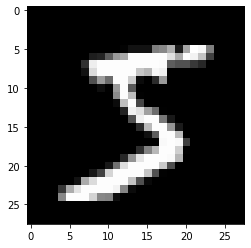

In [5]:
image, label = next(iter(train))

import matplotlib.pyplot as plt

plt.imshow(image.numpy().reshape(28,28),cmap = 'gray')

print('LABEL : ' , label)

In [6]:
x = [image.numpy().reshape(28,28) for image,label in iter(train)]

import numpy as np
x = np.array(x)

In [7]:
x.mean()

-0.00012829367

In [8]:
x.std()

1.0000249

In [9]:
# Download data
sample_data = datasets.MNIST('./data', train=True, download=True).data

np.mean(sample_data.numpy())

np.max(sample_data.numpy())

255

Data Statistics:
 - Data Shape: (60000, 28, 28)
 - min: 0.0
 - max: 1.0
 - mean: 0.1307
 - std: 0.3081
 - var: 0.0949



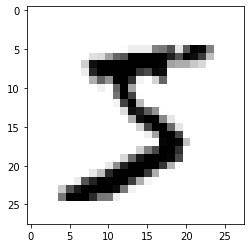

In [10]:
# Download data
sample_data = datasets.MNIST('./data', train=True, download=True).data

# Setting the values in the data to be within the range [0, 1]
sample_data = sample_data.numpy() / 255

# Display some data statistics
print('Data Statistics:')
print(' - Data Shape:', sample_data.shape)
print(' - min:', np.min(sample_data))
print(' - max:', np.max(sample_data))
print(' - mean: %.4f' % np.mean(sample_data))
print(' - std: %.4f' % np.std(sample_data))
print(' - var: %.4f\n' % np.var(sample_data))

# Visualize a sample from the data
plt.imshow(sample_data[0], cmap='gray_r')

In [11]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)




CUDA Available? True


SyntaxError: ignored

In [18]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)

        self.pool  = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False)

        self.conv5 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        self.out = nn.AdaptiveAvgPool2d(1)

    def forward(self,x):

      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))

      x = self.pool(x)

      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))

      x = F.relu(self.conv5(x))

      x = self.out(x)
      x = x.view(-1, 10)

      return F.log_softmax(x, dim =1)

In [19]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [21]:
model = Net()
model = Net().to(device)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
            Conv2d-2           [-1, 16, 24, 24]           2,304
         MaxPool2d-3           [-1, 16, 12, 12]               0
            Conv2d-4           [-1, 16, 10, 10]           2,304
            Conv2d-5             [-1, 32, 8, 8]           4,608
            Conv2d-6             [-1, 10, 8, 8]             320
 AdaptiveAvgPool2d-7             [-1, 10, 1, 1]               0
Total params: 9,680
Trainable params: 9,680
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.04
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [23]:
epochs = 15

train_losses = []
test_losses = []

train_correct = []
test_correct = []

for i in range(epochs):
    
    correct_classified = 0
    for batch_number , (x_train,y_train) in enumerate(train_loader):
        
        batch_number+=1
        
        x_train,y_train = x_train.to(device), y_train.to(device)
        pred = model.forward(x_train)
        loss = criterion(pred,y_train)
        
        #pred.argmax(dim=1, keepdim=True)
        #PyTorch .eq() function to do this, which compares the values in two tensors and if they match, returns a 1. If they don’t match, it returns a 0:
        #correct += pred.eq(target.view_as(pred)).sum().item()
        predicted = torch.max(pred.data ,1)[1]
        correct_classified += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_number%100 == 0:
            
            acc = round((correct_classified.item())/(batch_number*128),5)
            print(f'(TRAIN) Epoch: {i:4} batch_number: {batch_number:4} Loss : {loss:4.4} Acc : {acc:4.5}')
        
    train_losses.append(loss) 
    train_correct.append(correct_classified)
    
    
    with torch.no_grad():
        
        test_loss = []
        correct_classified = 0
        for batch_number , (x_test,y_test) in enumerate(test_loader):
        
            x_test,y_test = x_test.to(device), y_test.to(device)
            pred = model.forward(x_test)
            loss = criterion(pred,y_test)
            test_losses.append(loss)
            
            correct_classified += (torch.max(pred,1)[1] == y_test).sum()
        
        avg_loss = torch.mean(torch.tensor(test_losses))
        test_losses.append(avg_loss)
        test_correct.append(correct_classified)
        
        acc = round(correct_classified.item()/10000,5)
        print('(TEST) Correct_classified : ' , correct_classified.item() ,' of 10000')
        print(f'(TEST) Epoch: {i:4} Loss : {avg_loss:4.4} Acc : {acc:4.5}')
        print('\n','*'*60 , '\n')

(TRAIN) Epoch:    0 batch_number:  100 Loss : 1.766 Acc : 0.27406
(TRAIN) Epoch:    0 batch_number:  200 Loss : 1.243 Acc : 0.43992
(TRAIN) Epoch:    0 batch_number:  300 Loss : 1.035 Acc : 0.53768
(TRAIN) Epoch:    0 batch_number:  400 Loss : 0.8291 Acc : 0.59947
(TEST) Correct_classified :  8253  of 10000
(TEST) Epoch:    0 Loss : 0.7452 Acc : 0.8253

 ************************************************************ 

(TRAIN) Epoch:    1 batch_number:  100 Loss : 0.681 Acc : 0.81492
(TRAIN) Epoch:    1 batch_number:  200 Loss : 0.5822 Acc : 0.81617
(TRAIN) Epoch:    1 batch_number:  300 Loss : 0.4902 Acc : 0.81896
(TRAIN) Epoch:    1 batch_number:  400 Loss : 0.5031 Acc : 0.82164
(TEST) Correct_classified :  8372  of 10000
(TEST) Epoch:    1 Loss : 0.6683 Acc : 0.8372

 ************************************************************ 

(TRAIN) Epoch:    2 batch_number:  100 Loss : 0.4036 Acc : 0.84016
(TRAIN) Epoch:    2 batch_number:  200 Loss : 0.2139 Acc : 0.86938
(TRAIN) Epoch:    2 batc

In [ ]:
test_losses